In [1]:
#Imports
%matplotlib inline
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt

from google.colab import files
uploaded = files.upload()


Saving metr-la.csv to metr-la.csv


In [2]:
#Loading and normalizing the data
def load_data(file_path, window_size):
    df = pd.read_csv(file_path)
    series = df.iloc[:, 1].astype(float).values
    series = (series - series.mean()) / series.std()

    #Splitting the data into training data and validation data
    split_index = int(len(series) * 0.8)
    train_series = series[:split_index]
    val_series = series[split_index - window_size:]

    # Building the training windows
    X_train, y_train = [], []
    for i in range(len(train_series) - window_size):
        X_train.append(train_series[i : i + window_size])
        y_train.append(train_series[i + window_size])

    #Building the validation windows
    X_val, y_val = [], []
    for i in range(len(val_series) - window_size):
        X_val.append(val_series[i : i + window_size])
        y_val.append(val_series[i + window_size])

    return(
        np.array(X_train, dtype=np.float32),
        np.array(y_train, dtype=np.float32),
        np.array(X_val, dtype=np.float32),
        np.array(y_val, dtype=np.float32),
    )

In [3]:
#Training function
def train_model(model, X_train, y_train, X_val, y_val, learning, batch_size, epochs):
    train_dataset = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
    val_dataset = TensorDataset(torch.from_numpy(X_val), torch.from_numpy(y_val))
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    criterion = nn.MSELoss()
    optimizer = Adam(model.parameters(), lr=learning)

    train_losses, val_losses = [], []
    start_time = time.time()

    for epoch in range(epochs):
        model.train()
        batch_losses = []
        #Training loop
        for xb, yb in train_loader:
            optimizer.zero_grad()
            preds = model(xb).squeeze(-1)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()
            batch_losses.append(loss.item())
        train_losses.append(np.mean(batch_losses))
        #Validation
        model.eval()
        with torch.no_grad():
            val_batch = [criterion(model(xb).squeeze(-1), yb).item() for xb, yb in val_loader]
        val_losses.append(np.mean(val_batch))
    training_time = time.time() - start_time
    return train_losses, val_losses, training_time

In [9]:
#Experiment code
def experiment(file_path, learning_rates, batch_sizes, hidden_nodes, epochs, window_size, runs):
    X_train, y_train, X_val, y_val = load_data(file_path,window_size)

    results = {}
    overall_start_time = time.time() #Track the full experiment time
    print("Starting experiment...")

    for learning in learning_rates:
        for batch in batch_sizes:
            for hidden in hidden_nodes:
                configs = f"learning={learning}_batch={batch}_hidden={hidden}"
                print(f"Running {configs}")
                all_runs = []

                for run in range(runs):
                    torch.manual_seed(run)
                    np.random.seed(run)
                    model = nn.Sequential(nn.Linear(window_size, hidden),nn.ReLU(), nn.Linear(hidden, 1))
                    train_loss, val_loss, train_time = train_model(model, X_train, y_train, X_val, y_val, learning, batch, epochs)

                    all_runs.append((train_loss, val_loss, train_time))

                #Average losses across runs
                avg_train = np.mean([running[0] for running in all_runs], axis=0)
                avg_val = np.mean([running[1] for running in all_runs], axis =0)
                avg_time = np.mean([running[2] for running in all_runs])
                final_train_loss = avg_train[-1]
                final_val_loss = avg_val[-1]

                print(f"Final Average Training Loss: {final_train_loss:.4f}")
                print(f"Final Average Validation Loss: {final_val_loss:.4f}")
                minutes, seconds = divmod(avg_time, 60)
                print(f"Average Training Time for this config: {int(minutes)} min {seconds:.2f} sec")

                #Plotting the graphs
                plt.figure()
                plt.plot(avg_train, label='Training Loss', linewidth=2)
                plt.plot(avg_val, label='Validation Loss', linewidth=2)
                plt.title(f"{configs}", fontsize=12, fontweight="bold")
                plt.xlabel('Epoch', fontsize=12)
                plt.ylabel('MSE Loss', fontsize=12)
                plt.legend()
                plt.grid(True, linestyle='--', linewidth=0.5)
                plt.tight_layout()
                plt.show()
                plt.close()

                results[configs] = {
                    "train_loss": avg_train,
                    "val_loss": avg_val,
                    "train_time": avg_time
                }

    overall_duration = time.time() - overall_start_time
    print(f"\nTotal Experiment Time: {overall_duration:.2f} seconds")
    return results

Starting experiment...
Running learning=0.0001_batch=32_hidden=16
Final Average Training Loss: 0.0870
Final Average Validation Loss: 0.0803
Average Training Time for this config: 1 min 6.01 sec


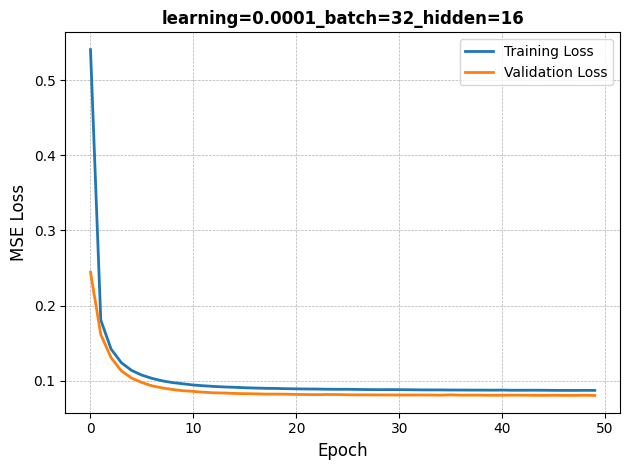

Running learning=0.0001_batch=32_hidden=32
Final Average Training Loss: 0.0863
Final Average Validation Loss: 0.0803
Average Training Time for this config: 1 min 5.36 sec


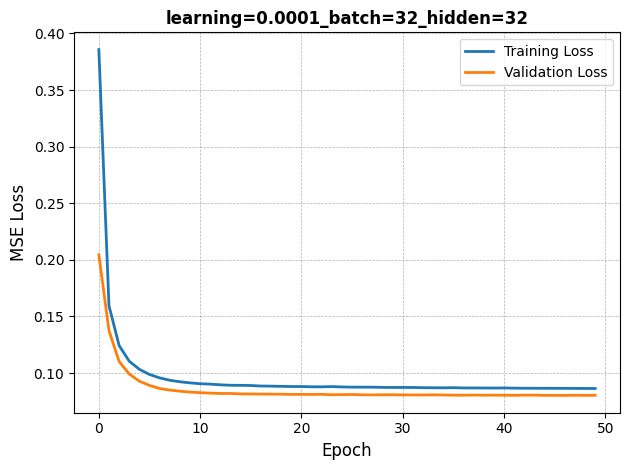

Running learning=0.0001_batch=32_hidden=64
Final Average Training Loss: 0.0854
Final Average Validation Loss: 0.0797
Average Training Time for this config: 1 min 6.06 sec


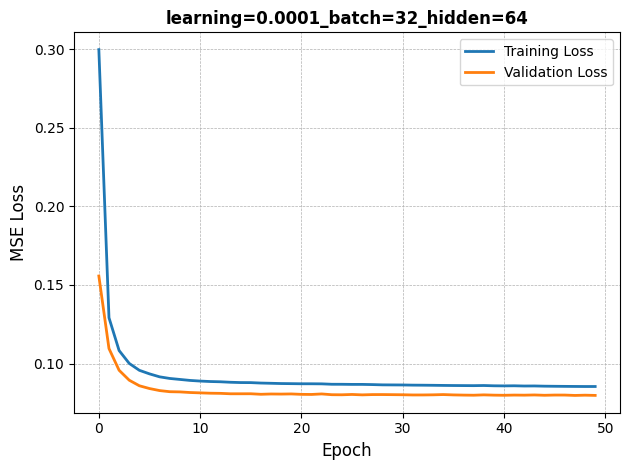

Running learning=0.0001_batch=32_hidden=80
Final Average Training Loss: 0.0853
Final Average Validation Loss: 0.0797
Average Training Time for this config: 1 min 5.36 sec


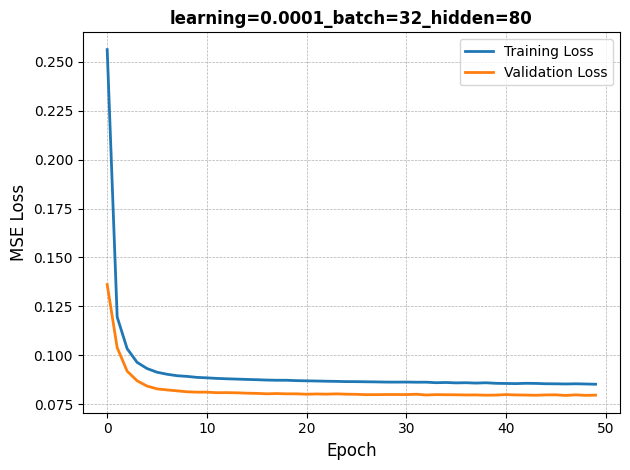

Running learning=0.0001_batch=48_hidden=16
Final Average Training Loss: 0.0873
Final Average Validation Loss: 0.0806
Average Training Time for this config: 0 min 48.46 sec


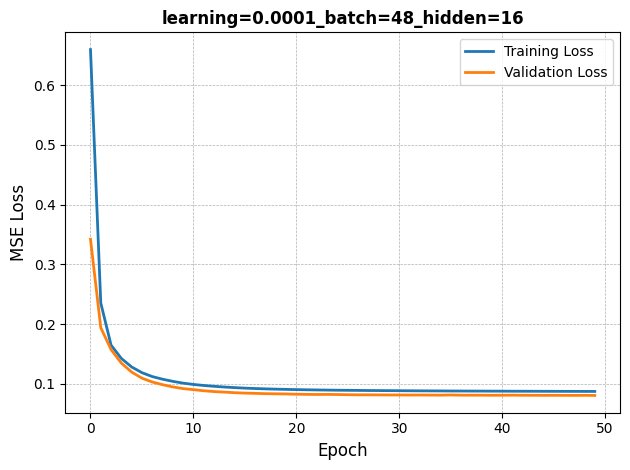

Running learning=0.0001_batch=48_hidden=32
Final Average Training Loss: 0.0867
Final Average Validation Loss: 0.0806
Average Training Time for this config: 0 min 48.49 sec


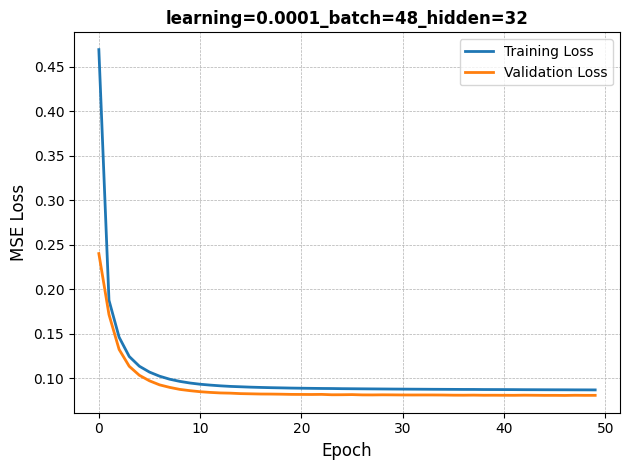

Running learning=0.0001_batch=48_hidden=64
Final Average Training Loss: 0.0858
Final Average Validation Loss: 0.0799
Average Training Time for this config: 0 min 49.20 sec


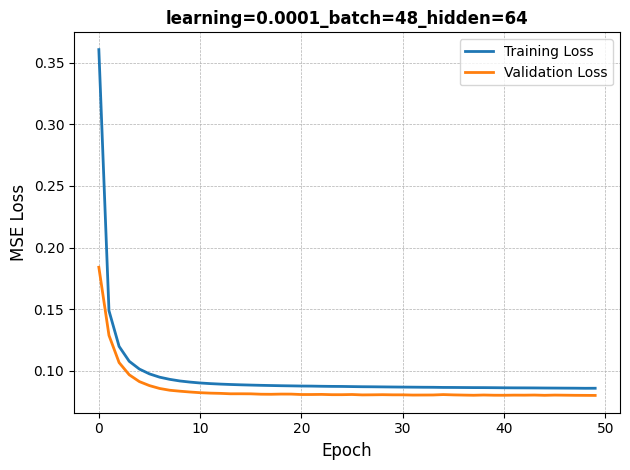

Running learning=0.0001_batch=48_hidden=80
Final Average Training Loss: 0.0857
Final Average Validation Loss: 0.0799
Average Training Time for this config: 0 min 49.21 sec


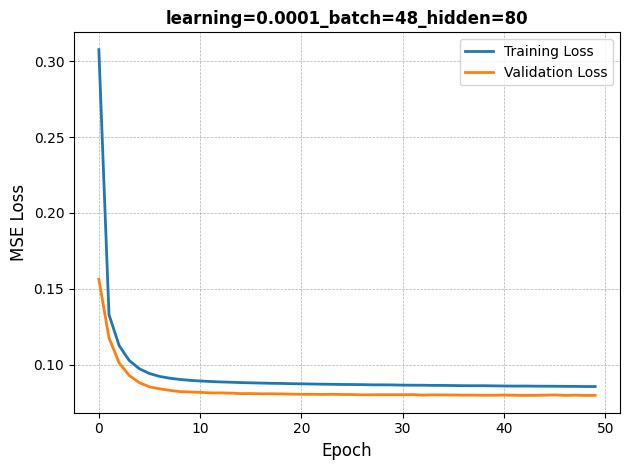

Running learning=0.0001_batch=64_hidden=16
Final Average Training Loss: 0.0878
Final Average Validation Loss: 0.0804
Average Training Time for this config: 0 min 40.25 sec


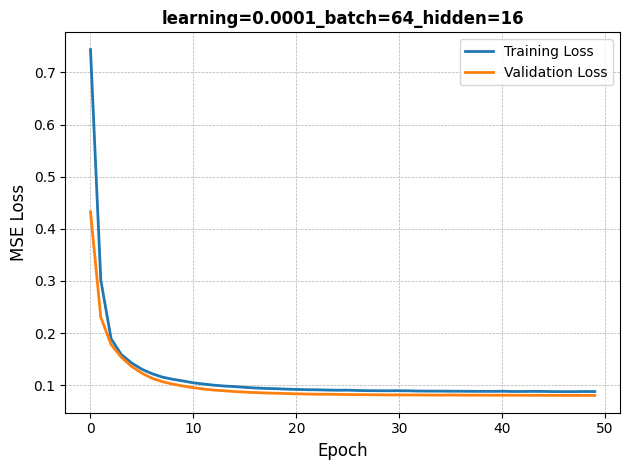

Running learning=0.0001_batch=64_hidden=32
Final Average Training Loss: 0.0869
Final Average Validation Loss: 0.0803
Average Training Time for this config: 0 min 40.24 sec


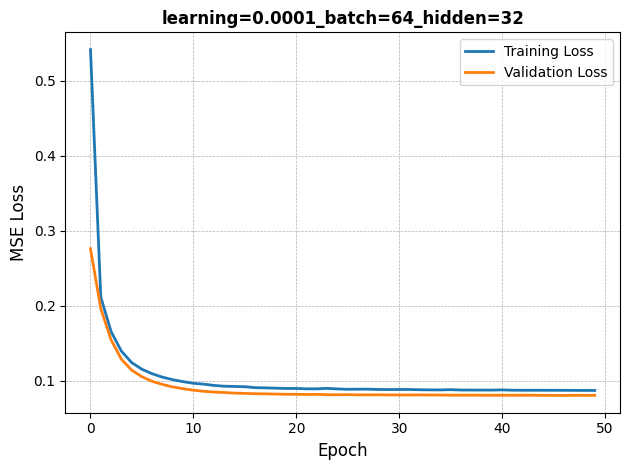

Running learning=0.0001_batch=64_hidden=64
Final Average Training Loss: 0.0860
Final Average Validation Loss: 0.0797
Average Training Time for this config: 0 min 41.20 sec


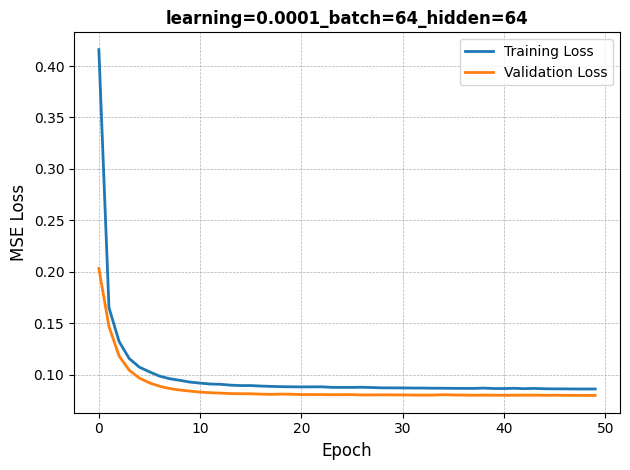

Running learning=0.0001_batch=64_hidden=80
Final Average Training Loss: 0.0859
Final Average Validation Loss: 0.0795
Average Training Time for this config: 0 min 41.42 sec


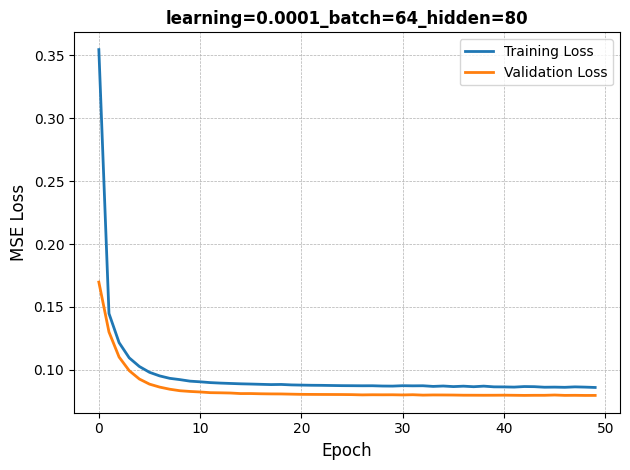

Running learning=0.0001_batch=128_hidden=16
Final Average Training Loss: 0.0895
Final Average Validation Loss: 0.0816
Average Training Time for this config: 0 min 27.28 sec


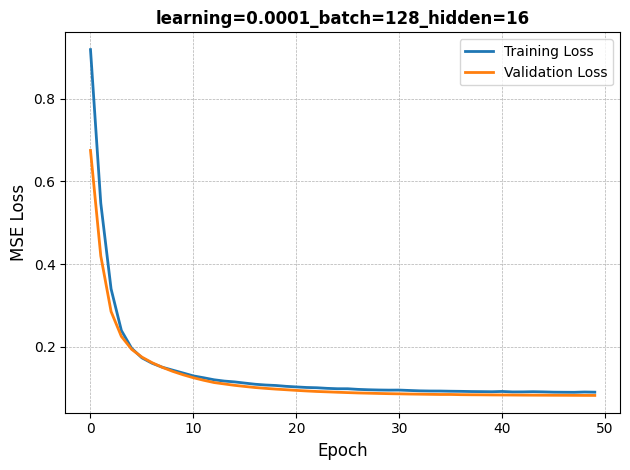

Running learning=0.0001_batch=128_hidden=32
Final Average Training Loss: 0.0876
Final Average Validation Loss: 0.0809
Average Training Time for this config: 0 min 27.78 sec


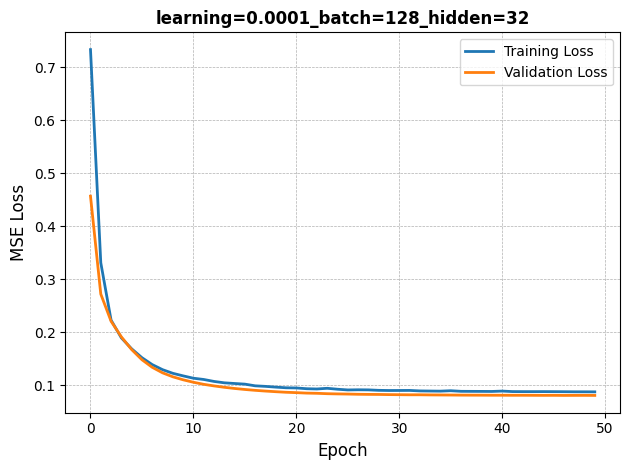

Running learning=0.0001_batch=128_hidden=64
Final Average Training Loss: 0.0866
Final Average Validation Loss: 0.0801
Average Training Time for this config: 0 min 27.84 sec


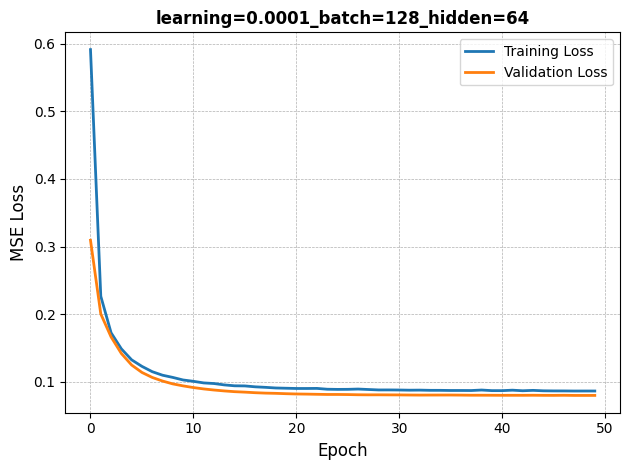

Running learning=0.0001_batch=128_hidden=80
Final Average Training Loss: 0.0866
Final Average Validation Loss: 0.0800
Average Training Time for this config: 0 min 28.20 sec


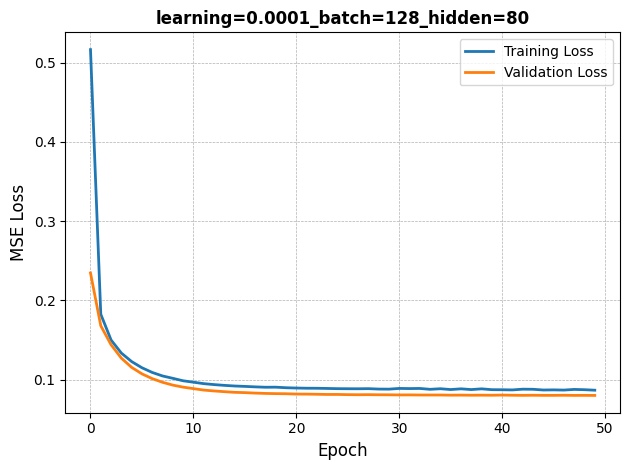

Running learning=0.001_batch=32_hidden=16
Final Average Training Loss: 0.0852
Final Average Validation Loss: 0.0794
Average Training Time for this config: 1 min 4.91 sec


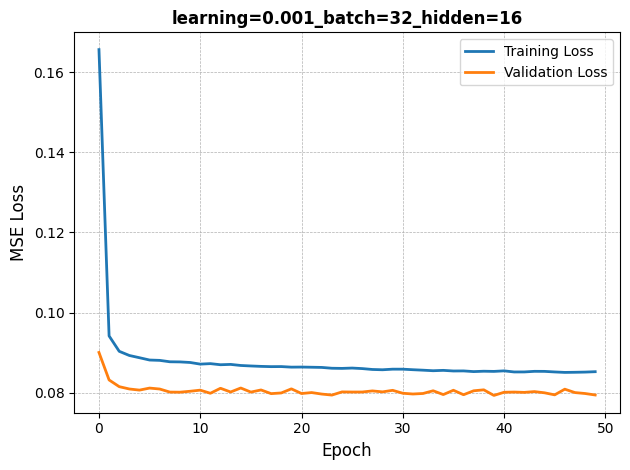

Running learning=0.001_batch=32_hidden=32
Final Average Training Loss: 0.0835
Final Average Validation Loss: 0.0799
Average Training Time for this config: 1 min 5.14 sec


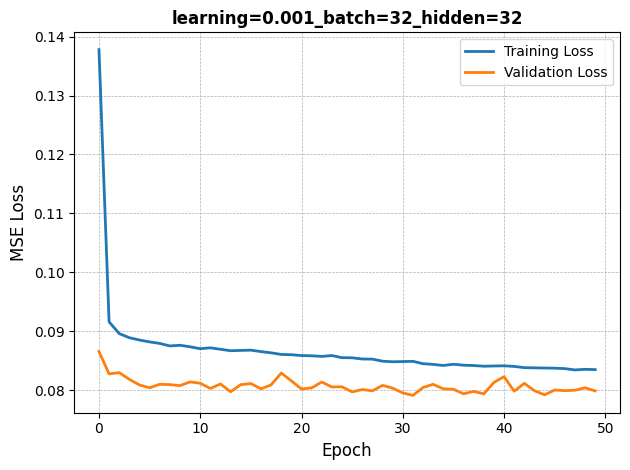

Running learning=0.001_batch=32_hidden=64
Final Average Training Loss: 0.0817
Final Average Validation Loss: 0.0797
Average Training Time for this config: 1 min 5.07 sec


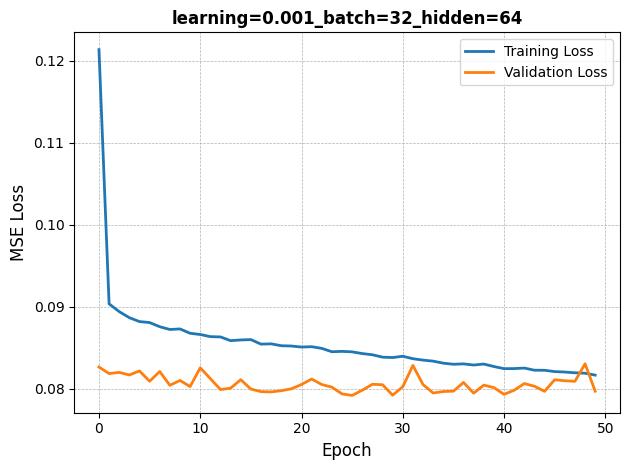

Running learning=0.001_batch=32_hidden=80
Final Average Training Loss: 0.0812
Final Average Validation Loss: 0.0801
Average Training Time for this config: 1 min 5.65 sec


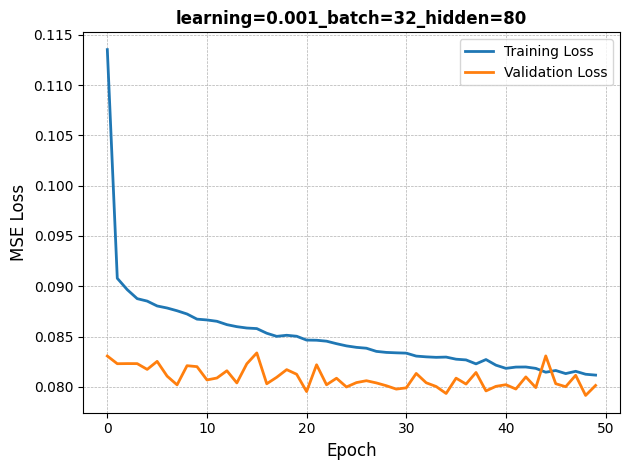

Running learning=0.001_batch=48_hidden=16
Final Average Training Loss: 0.0852
Final Average Validation Loss: 0.0794
Average Training Time for this config: 0 min 48.05 sec


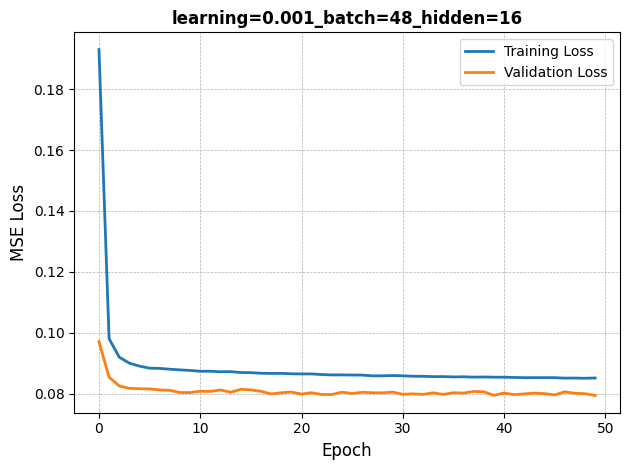

Running learning=0.001_batch=48_hidden=32
Final Average Training Loss: 0.0839
Final Average Validation Loss: 0.0798
Average Training Time for this config: 0 min 48.34 sec


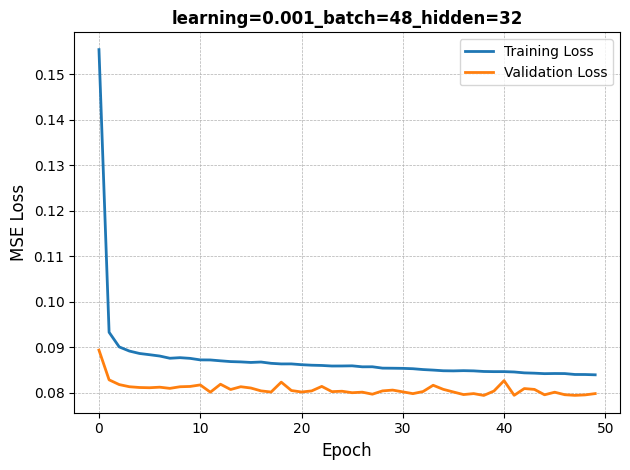

Running learning=0.001_batch=48_hidden=64
Final Average Training Loss: 0.0821
Final Average Validation Loss: 0.0793
Average Training Time for this config: 0 min 49.07 sec


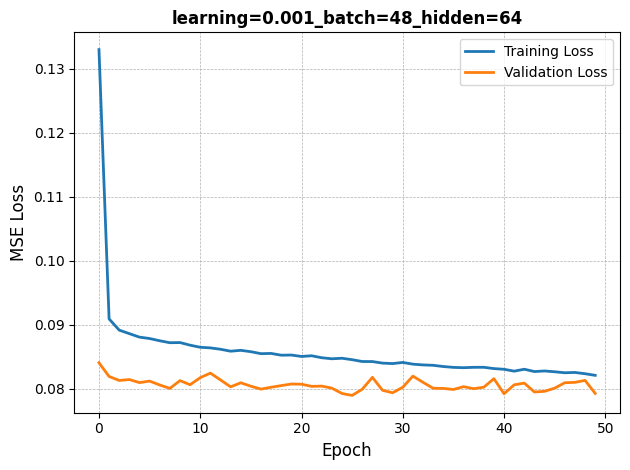

Running learning=0.001_batch=48_hidden=80
Final Average Training Loss: 0.0820
Final Average Validation Loss: 0.0800
Average Training Time for this config: 0 min 49.62 sec


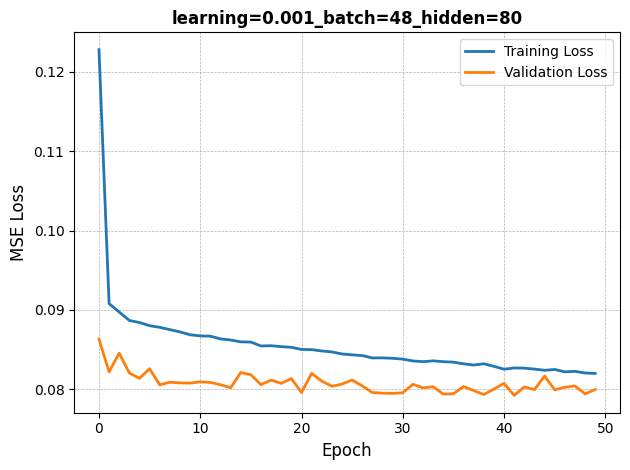

Running learning=0.001_batch=64_hidden=16
Final Average Training Loss: 0.0853
Final Average Validation Loss: 0.0789
Average Training Time for this config: 0 min 39.80 sec


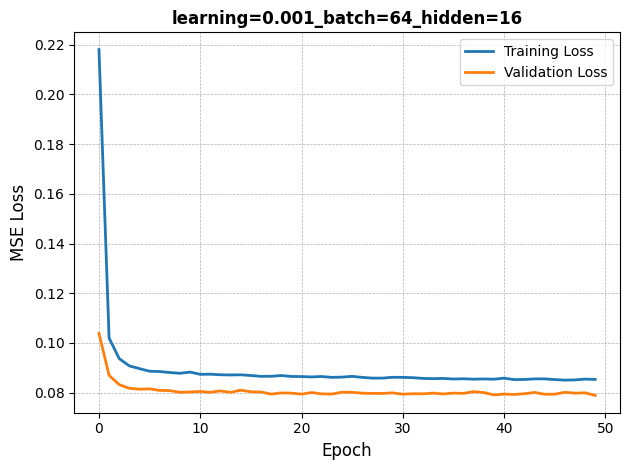

Running learning=0.001_batch=64_hidden=32
Final Average Training Loss: 0.0841
Final Average Validation Loss: 0.0797
Average Training Time for this config: 0 min 40.41 sec


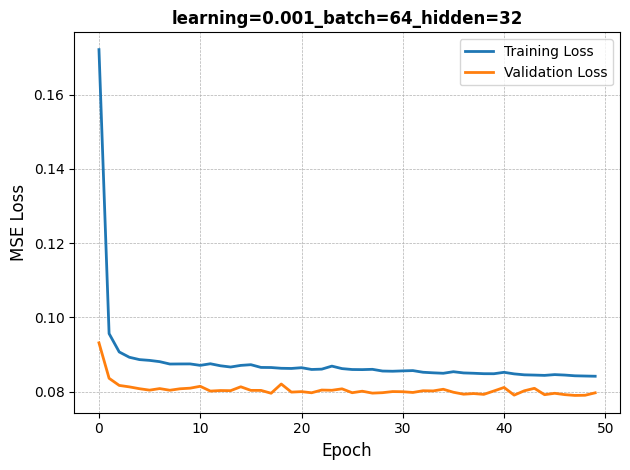

Running learning=0.001_batch=64_hidden=64
Final Average Training Loss: 0.0825
Final Average Validation Loss: 0.0787
Average Training Time for this config: 0 min 40.79 sec


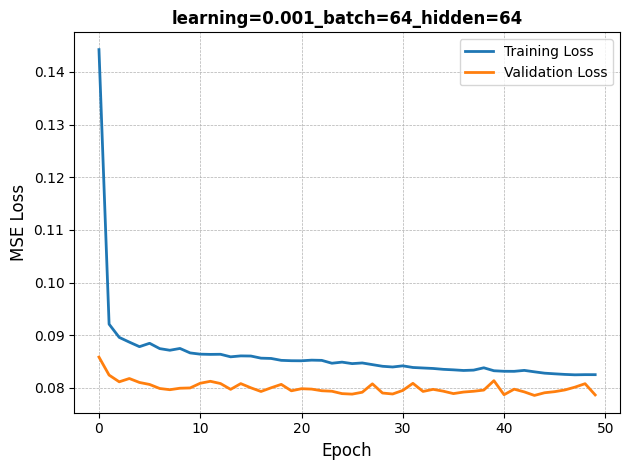

Running learning=0.001_batch=64_hidden=80
Final Average Training Loss: 0.0821
Final Average Validation Loss: 0.0793
Average Training Time for this config: 0 min 41.33 sec


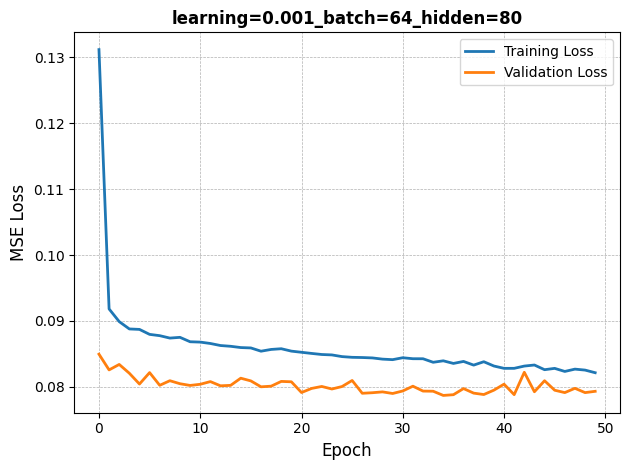

Running learning=0.001_batch=128_hidden=16
Final Average Training Loss: 0.0858
Final Average Validation Loss: 0.0790
Average Training Time for this config: 0 min 27.50 sec


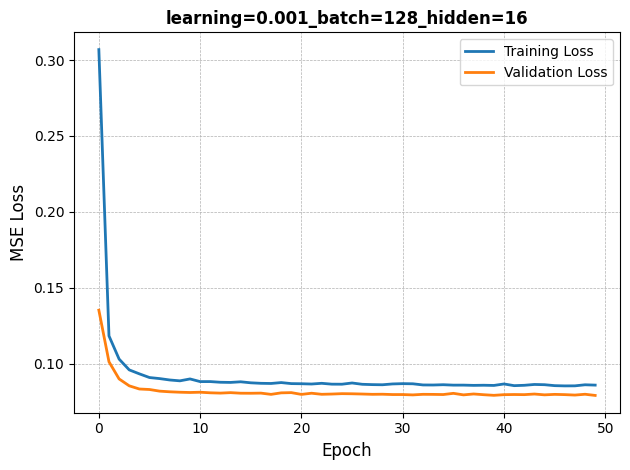

Running learning=0.001_batch=128_hidden=32
Final Average Training Loss: 0.0845
Final Average Validation Loss: 0.0799
Average Training Time for this config: 0 min 27.45 sec


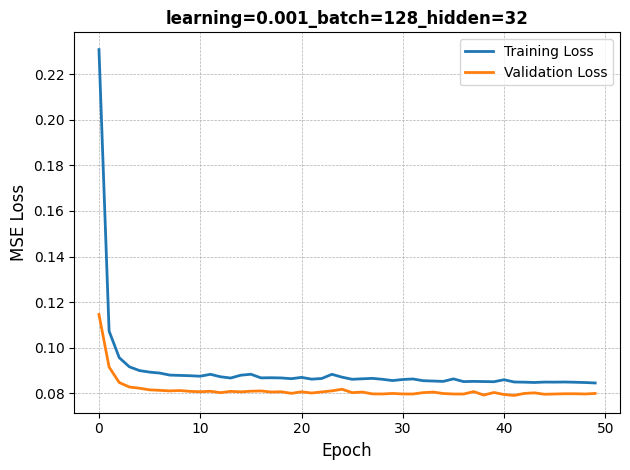

Running learning=0.001_batch=128_hidden=64
Final Average Training Loss: 0.0832
Final Average Validation Loss: 0.0798
Average Training Time for this config: 0 min 28.14 sec


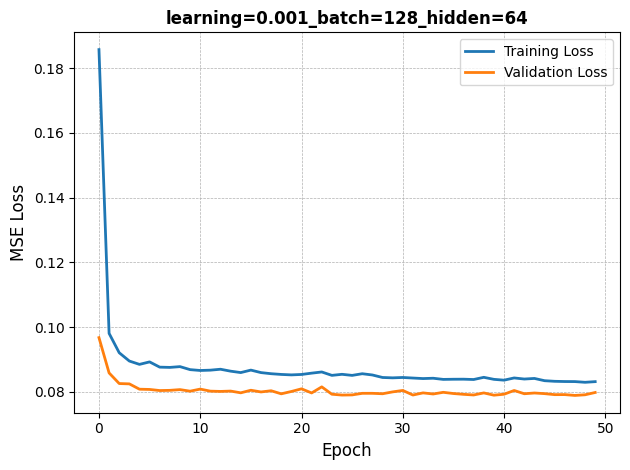

Running learning=0.001_batch=128_hidden=80
Final Average Training Loss: 0.0828
Final Average Validation Loss: 0.0792
Average Training Time for this config: 0 min 28.15 sec


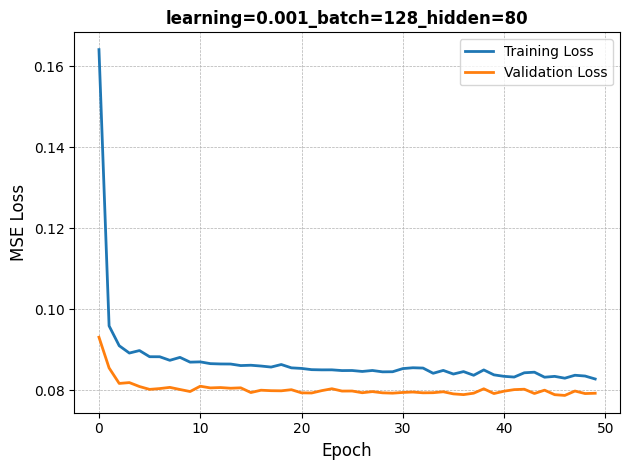

Running learning=0.01_batch=32_hidden=16
Final Average Training Loss: 0.0890
Final Average Validation Loss: 0.0855
Average Training Time for this config: 1 min 5.39 sec


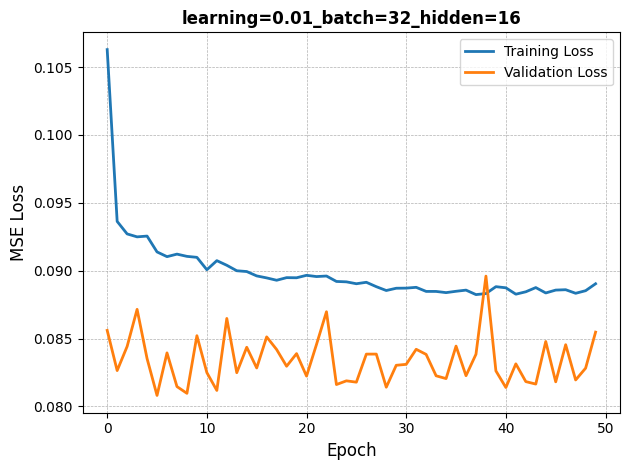

Running learning=0.01_batch=32_hidden=32
Final Average Training Loss: 0.0871
Final Average Validation Loss: 0.0867
Average Training Time for this config: 1 min 6.06 sec


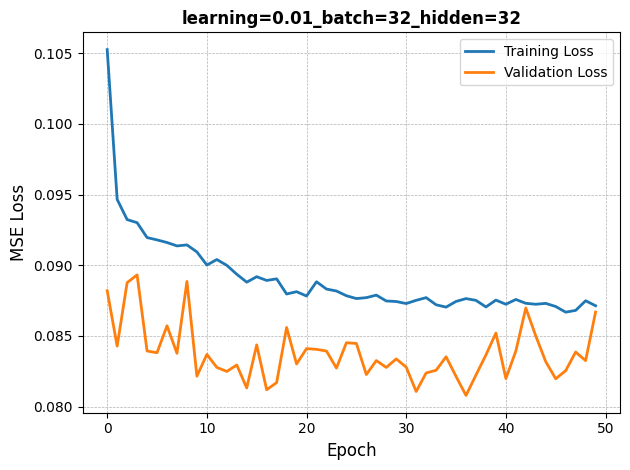

Running learning=0.01_batch=32_hidden=64
Final Average Training Loss: 0.0868
Final Average Validation Loss: 0.0820
Average Training Time for this config: 1 min 6.26 sec


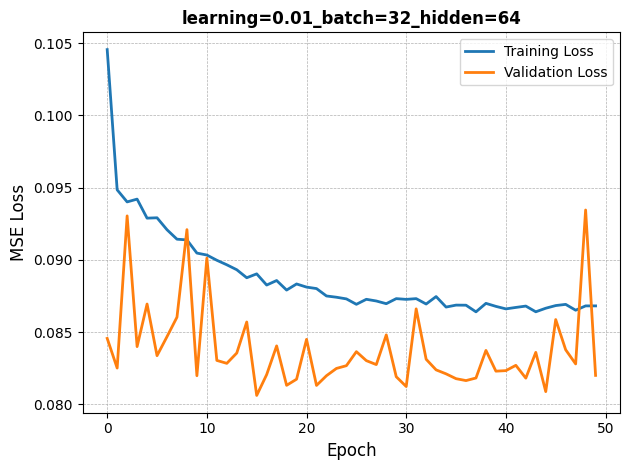

Running learning=0.01_batch=32_hidden=80
Final Average Training Loss: 0.0863
Final Average Validation Loss: 0.0826
Average Training Time for this config: 1 min 6.41 sec


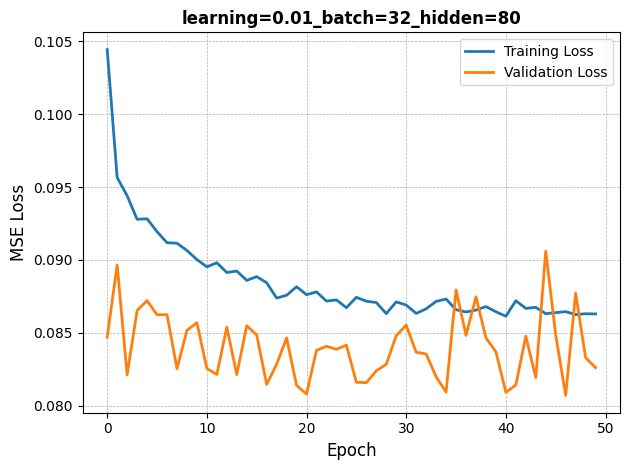

Running learning=0.01_batch=48_hidden=16
Final Average Training Loss: 0.0871
Final Average Validation Loss: 0.0816
Average Training Time for this config: 0 min 48.65 sec


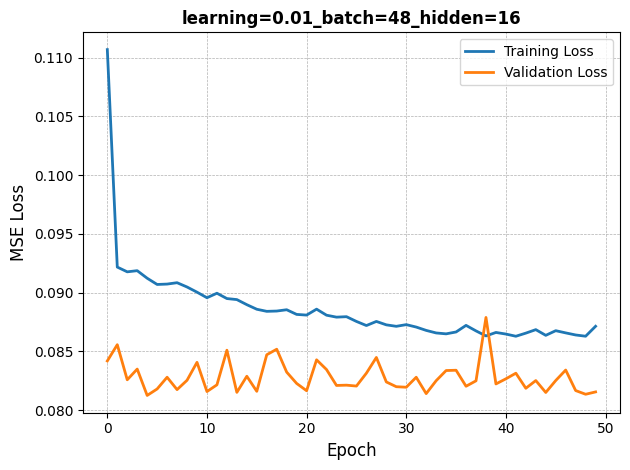

Running learning=0.01_batch=48_hidden=32
Final Average Training Loss: 0.0853
Final Average Validation Loss: 0.0820
Average Training Time for this config: 0 min 48.61 sec


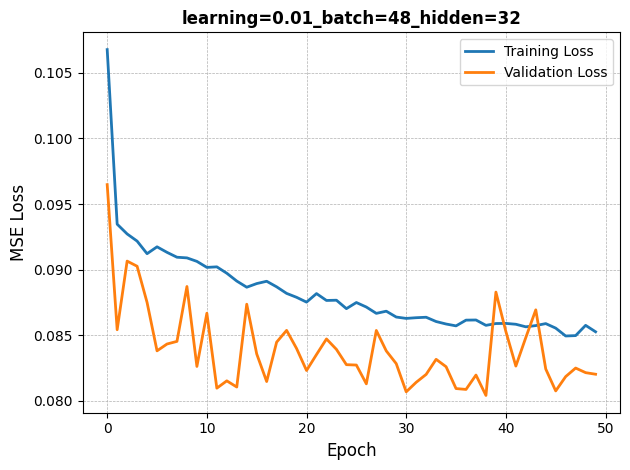

Running learning=0.01_batch=48_hidden=64
Final Average Training Loss: 0.0851
Final Average Validation Loss: 0.0822
Average Training Time for this config: 0 min 49.50 sec


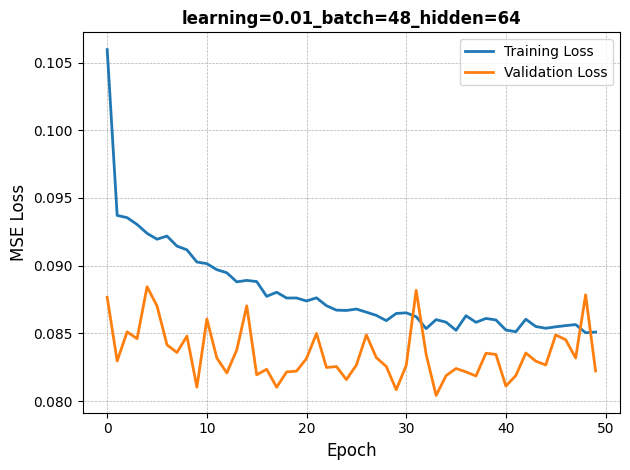

Running learning=0.01_batch=48_hidden=80
Final Average Training Loss: 0.0848
Final Average Validation Loss: 0.0815
Average Training Time for this config: 0 min 49.77 sec


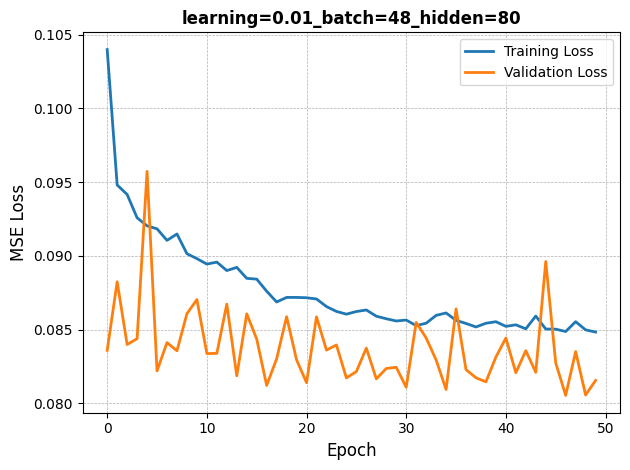

Running learning=0.01_batch=64_hidden=16
Final Average Training Loss: 0.0852
Final Average Validation Loss: 0.0807
Average Training Time for this config: 0 min 39.94 sec


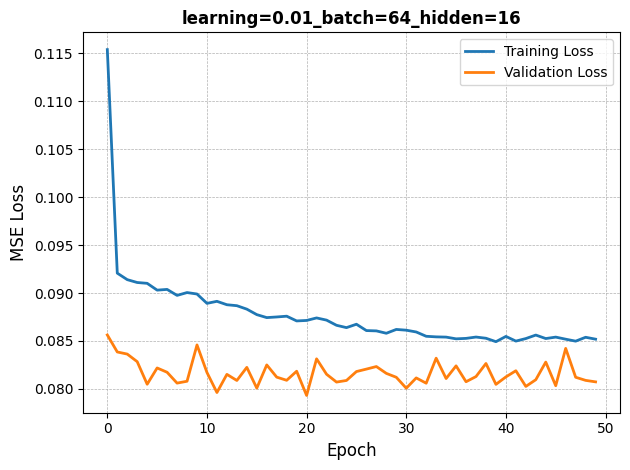

Running learning=0.01_batch=64_hidden=32
Final Average Training Loss: 0.0846
Final Average Validation Loss: 0.0809
Average Training Time for this config: 0 min 40.18 sec


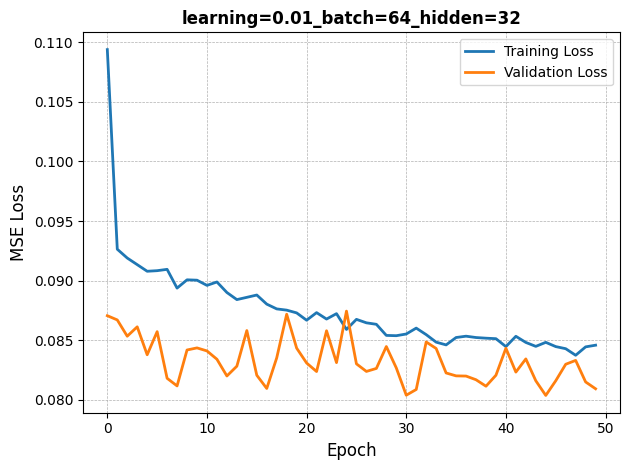

Running learning=0.01_batch=64_hidden=64
Final Average Training Loss: 0.0840
Final Average Validation Loss: 0.0815
Average Training Time for this config: 0 min 41.03 sec


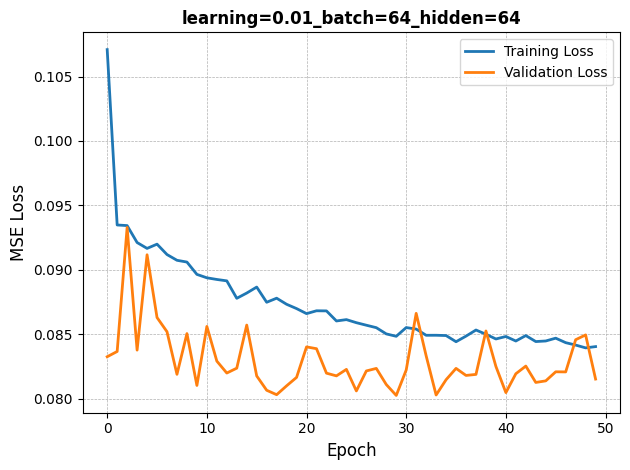

Running learning=0.01_batch=64_hidden=80
Final Average Training Loss: 0.0843
Final Average Validation Loss: 0.0815
Average Training Time for this config: 0 min 41.28 sec


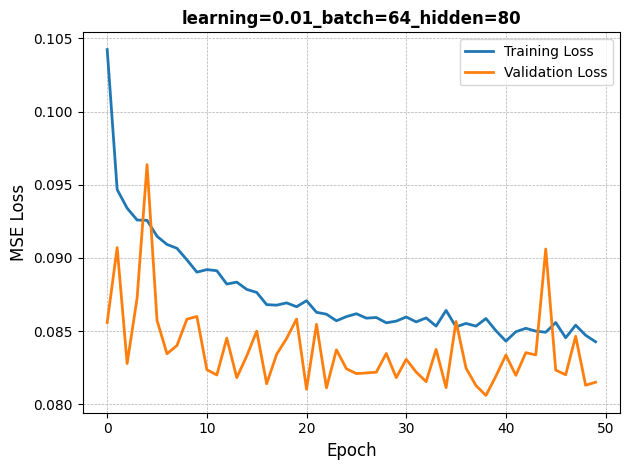

Running learning=0.01_batch=128_hidden=16
Final Average Training Loss: 0.0846
Final Average Validation Loss: 0.0799
Average Training Time for this config: 0 min 26.94 sec


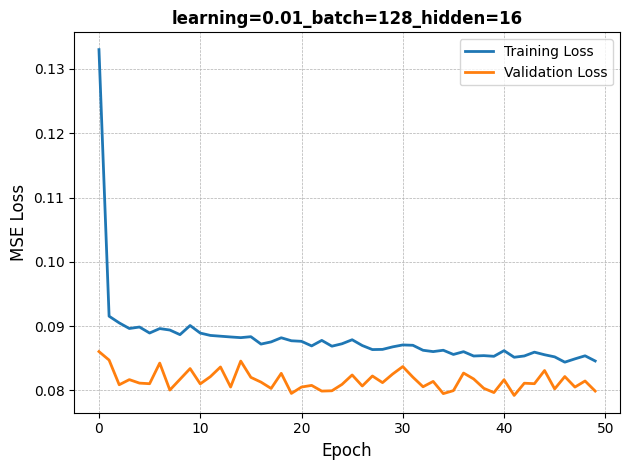

Running learning=0.01_batch=128_hidden=32
Final Average Training Loss: 0.0831
Final Average Validation Loss: 0.0807
Average Training Time for this config: 0 min 27.60 sec


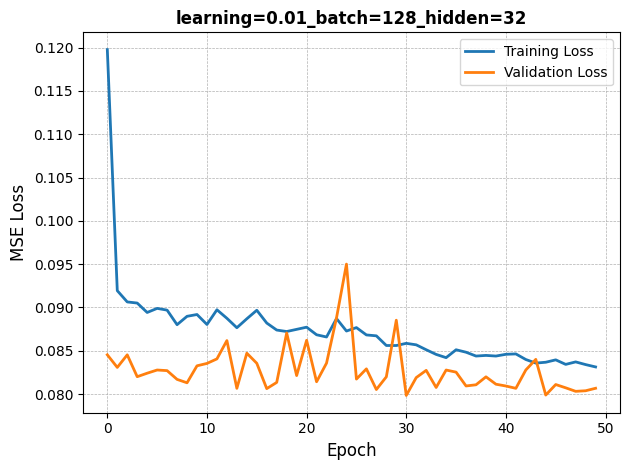

Running learning=0.01_batch=128_hidden=64
Final Average Training Loss: 0.0830
Final Average Validation Loss: 0.0806
Average Training Time for this config: 0 min 28.07 sec


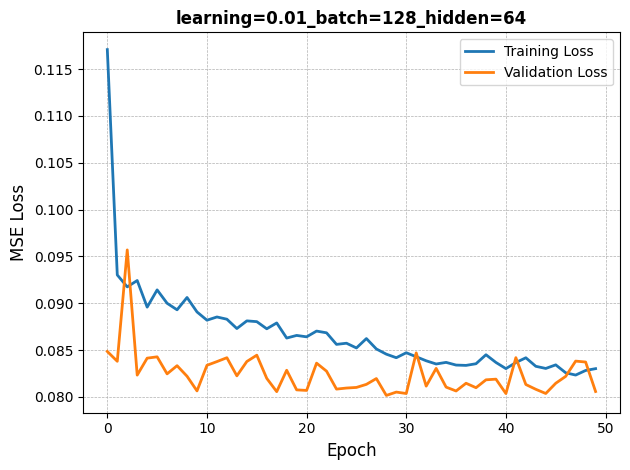

Running learning=0.01_batch=128_hidden=80
Final Average Training Loss: 0.0831
Final Average Validation Loss: 0.0803
Average Training Time for this config: 0 min 27.80 sec


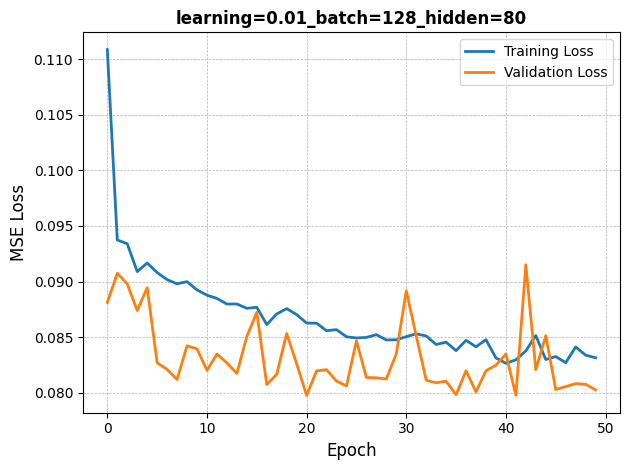


⏱️ Total Experiment Time: 6595.71 seconds


In [10]:
#Main Function
if __name__ == '__main__':
    #file_path = "C:/Users/acer/OneDrive/Desktop/Masters/CSC5025Z - Intelligent Systems/Assignments/metr-la.csv"
    file_path = 'metr-la.csv'
    #Hyperparameters
    learning_rates = [0.0001, 0.001, 0.01]
    batch_sizes = [32, 48, 64, 128]
    hidden_nodes = [16, 32, 64, 80]
    epochs = 50
    window_size = 12
    runs = 3

    experiment(
        file_path,
        learning_rates,
        batch_sizes,
        hidden_nodes,
        epochs,
        window_size,
        runs
    )
